# <center>ST590 Final Project</center>

#### <center>Pramodini Karwande and Ashley Ko </center>

## Introduction

**This section is in progress. I have started writing some preliminary things that we can use to form an introductory section**



We will be exploring data from `heart.csv`. It was obtained via kaggle.com. https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

We will be using this data set to classify individuals as either having heart disease or not. This is a binary data set.
We will use a classification tree, bagging, random forest and logistic regression to select and fit models and predict the presence of heart disease.

## Supervised Learning Concepts

In [ ]:
## TO DO: DESCRIBE SUPERVISED LEARNING CONCEPTS

## Data Split

In [54]:
## TO DO: CALL PACKAGES

import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

import pandas as pd
import numpy as np
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

<p  style="color:#ff6633;"> Now read in a data set using `pandas on spark`</p>

In [18]:
## TO DO: READ IN DATA HERE
psdf_heart = ps.read_csv("heart.csv")
psdf_heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [19]:
# convert categorical variables into `category` type variable
psdf_heart.Sex = psdf_heart.Sex.astype("category")
psdf_heart.ChestPainType = psdf_heart.ChestPainType.astype("category")
psdf_heart.RestingECG = psdf_heart.RestingECG.astype("category")
psdf_heart.ExerciseAngina = psdf_heart.ExerciseAngina.astype("category")
psdf_heart.ST_Slope = psdf_heart.ST_Slope.astype("category")
psdf_heart.HeartDisease = psdf_heart.HeartDisease.astype("category")

psdf_heart.info()


<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             918 non-null    int32   
 1   Sex             918 non-null    category
 2   ChestPainType   918 non-null    category
 3   RestingBP       918 non-null    int32   
 4   Cholesterol     918 non-null    int32   
 5   FastingBS       918 non-null    int32   
 6   RestingECG      918 non-null    category
 7   MaxHR           918 non-null    int32   
 8   ExerciseAngina  918 non-null    category
 9   Oldpeak         918 non-null    float64 
 10  ST_Slope        918 non-null    category
 11  HeartDisease    918 non-null    category
dtypes: category(6), float64(1), int32(5)

## Exploratory Data Analysis

### Numerical Summaries

<p  style="color:#ff6633;"> Let's first see any missing values to handle the data properly. </p>

In [33]:
# check for null values
print(psdf_heart.isnull().sum())

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


<p  style="color:#ff6633;"> Using pandas-on-Spark, below is the summary for the variables : `Age`, `RestingBP`, `Cholesterol`, `MaxHR`, `Oldpeak` variables </p>

In [51]:
psdf_heart[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.000000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


<p  style="color:#ff6633;"> Let's repeat above task to get mean and std for the given variables for HeartDisease based on sex. </p>

In [35]:
psdf_heart_summ_group = psdf_heart.groupby('HeartDisease').agg({'Age': ['mean', 'std'], 'RestingBP': ['mean', 'std'], \
                                  'Cholesterol': ['mean', 'std'], 'MaxHR': ['mean', 'std'], \
                                  'Oldpeak': ['mean', 'std'] \
                          })
psdf_heart_summ_group

Age             RestingBP            Cholesterol                   MaxHR              Oldpeak          
                   mean       std        mean        std        mean         std        mean        std      mean       std
HeartDisease                                                                                                               
1             55.899606  8.727056  134.185039  19.828685  175.940945  126.391398  127.655512  23.386923  1.274213  1.151872
0             50.551220  9.444915  130.180488  16.499585  227.121951   74.634659  148.151220  23.288067  0.408049  0.699709

In [36]:
psdf_heart_summ_sex = psdf_heart.groupby('Sex').agg({'Age': ['mean', 'std'], 'RestingBP': ['mean', 'std'], \
                                  'Cholesterol': ['mean', 'std'], 'MaxHR': ['mean', 'std'], \
                                  'Oldpeak': ['mean', 'std'] \
                          })
psdf_heart_summ_sex

Age             RestingBP            Cholesterol                   MaxHR              Oldpeak          
          mean       std        mean        std        mean         std        mean        std      mean       std
Sex                                                                                                               
M    53.782069  9.397864  132.445517  18.286739  187.513103  112.351444  134.325517  25.719191  0.945517  1.087154
F    52.492228  9.517593  132.212435  19.392638  241.196891   85.195441  146.139896  22.154902  0.668912  0.956865

C:\Users\kar_d\anaconda3\lib\site-packages\pyspark\pandas\indexes\base.py:589: UserWarning:

We recommend using `CategoricalIndex.to_numpy()` instead.

C:\Users\kar_d\anaconda3\lib\site-packages\pyspark\pandas\generic.py:638: UserWarning:

We recommend using `Series.to_numpy()` instead.



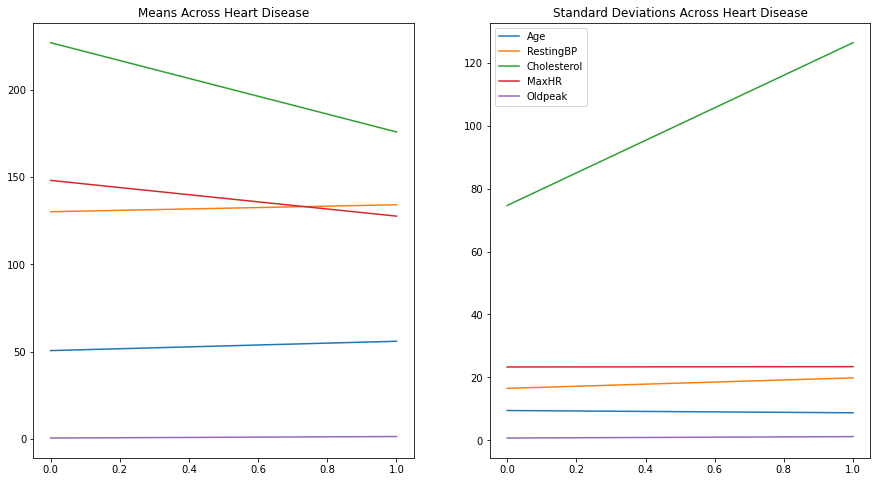

In [67]:
# Using plots, we will observe the trend of means and std across the age

figure, axis = plt.subplots(1, 2,figsize=(15, 8))

axis[0].plot(psdf_heart_summ_group[('Age', 'mean')], label = "Age")
axis[0].plot(psdf_heart_summ_group[('RestingBP', 'mean')], label = "RestingBP")
axis[0].plot(psdf_heart_summ_group[('Cholesterol', 'mean')], label = "Cholesterol")
axis[0].plot(psdf_heart_summ_group[('MaxHR', 'mean')], label = "MaxHR")
axis[0].plot(psdf_heart_summ_group[('Oldpeak', 'mean')], label = "Oldpeak")

axis[0].set_title("Means Across Heart Disease")

axis[1].plot(psdf_heart_summ_group[('Age', 'std')], label = "Age")
axis[1].plot(psdf_heart_summ_group[('RestingBP', 'std')], label = "RestingBP")
axis[1].plot(psdf_heart_summ_group[('Cholesterol', 'std')], label = "Cholesterol")
axis[1].plot(psdf_heart_summ_group[('MaxHR', 'std')], label = "MaxHR")
axis[1].plot(psdf_heart_summ_group[('Oldpeak', 'std')], label = "Oldpeak")

axis[1].set_title("Standard Deviations Across Heart Disease")

plt.legend()

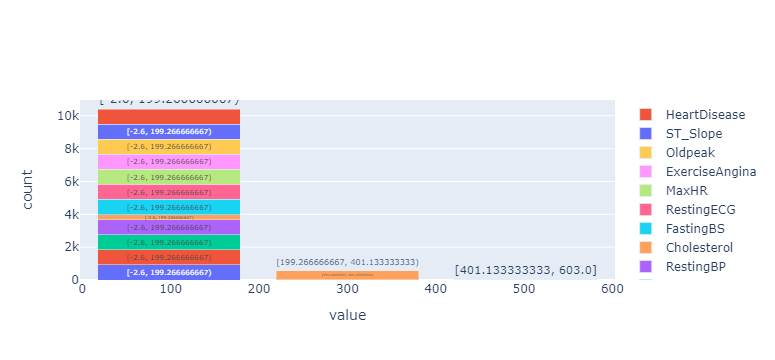

In [73]:
psdf_heart.plot.hist(bins=3, alpha=0.5)


In [52]:
psdf_heart.corr()

C:\Users\kar_d\anaconda3\lib\site-packages\pyspark\sql\context.py:125: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
Age,1.000000,0.254399,-0.095282,0.198039,-0.382045,0.258612
RestingBP,0.254399,1.000000,0.100893,0.070193,-0.112135,0.164803
Cholesterol,-0.095282,0.100893,1.000000,-0.260974,0.235792,0.050148
FastingBS,0.198039,0.070193,-0.260974,1.000000,-0.131438,0.052698
MaxHR,-0.382045,-0.112135,0.235792,-0.131438,1.000000,-0.160691
Oldpeak,0.258612,0.164803,0.050148,0.052698,-0.160691,1.000000


### Graphical Summaries

## Modeling

In [ ]:
### Classification Tree

In [ ]:
### Random Forest

## Conclusion